# AI과정 miniProject
### FIFA 선수 이적료 예측 경진대회 ( Dataset from DACON )

- FIFA_train.csv / FIFA_test.csv
- Player Dataset Column Information
  - id : 선수 고유의 아이디
  - name : 이름
  - age : 나이
  - continent : 선수들의 국적이 포함되어 있는 대륙입니다
  - contract_until : 선수의 계약기간이 언제까지인지 나타내어 줍니다
  - position : 선수가 선호하는 포지션입니다. ex) 공격수, 수비수 등
  - prefer_foot : 선수가 선호하는 발입니다. ex) 오른발
  - reputation : 선수가 유명한 정도입니다. ex) 높은 수치일 수록 유명한 선수
  - stat_overall : 선수의 현재 능력치 입니다.
  - stat_potential : 선수가 경험 및 노력을 통해 발전할 수 있는 정도입니다.
  - stat_skill_moves : 선수의 개인기 능력치 입니다.
  - value : FIFA가 선정한 선수의 이적 시장 가격 (단위 : 유로) 입니다



- submission.csv
- id 값을 통해 value 값을 추출해야 한다.
  - id : 선수 고유의 아이디
  - value : 예측된 선수 이적 시장 가격을 기입
  
  

In [169]:
# module import
## pandas, numpy
import numpy as np
import pandas as pd

# Visualization Module
## matplotlib, seaborn
import matplotlib.pyplot as plt
import seaborn as sns

# gif
from matplotlib.animation import FuncAnimation

# ignore warning
import warnings
warnings.filterwarnings(action='ignore')


In [229]:
# Data load
## 이건 나중에 맞춰야 할듯 합니다. 우선은 에러 줄이기 위해 local에서 진행

train_df = pd.read_csv('.\\data\\FIFA_train.csv')
test_df = pd.read_csv('.\\data\\FIFA_test.csv')
submission_df = pd.read_csv('.\\data\\submission.csv')
#submission_df = pd.read_csv('.\\data\\submission.csv')

train = train_df.copy()
test = test_df.copy()

In [171]:
# Data Check

train_df.head()

id          name  age      continent contract_until position prefer_foot  \
0   0      L. Messi   31  south america           2021       ST        left   
1   3        De Gea   27         europe           2020       GK       right   
2   7     L. Suárez   31  south america           2021       ST       right   
3   8  Sergio Ramos   32         europe           2020       DF       right   
4   9      J. Oblak   25         europe           2021       GK       right   

   reputation  stat_overall  stat_potential  stat_skill_moves        value  
0         5.0            94              94               4.0  110500000.0  
1         4.0            91              93               1.0   72000000.0  
2         5.0            91              91               3.0   80000000.0  
3         4.0            91              91               3.0   51000000.0  
4         3.0            90              93               1.0   68000000.0

## Data Time insight

1. 데이터 내의 나이와 현재 나이의 차를 통해 데이터 생성 시기는 "2018년"으로 간주


2. Data 의 value 값의 단위는 EUR(€, 유로), 하지만 편하게 분석, 해석 하기 위해. 대한민국의 화폐 단위인 원단위로 변경 후 작업


3. 원단위로 변경은 데이터 생성 시기인 2018년의 원화<>유로 환률의 평균값으로 계산

4. 1 EUR(€, 유로) = 1299.65 원 (\, 원화)로 가정하고 작업 진행

5. 시각화는 EUR(€, 유로)로 진행

In [172]:
# Data 이상치, NaN값 타입 확인

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                8932 non-null   int64  
 1   name              8932 non-null   object 
 2   age               8932 non-null   int64  
 3   continent         8932 non-null   object 
 4   contract_until    8932 non-null   object 
 5   position          8932 non-null   object 
 6   prefer_foot       8932 non-null   object 
 7   reputation        8932 non-null   float64
 8   stat_overall      8932 non-null   int64  
 9   stat_potential    8932 non-null   int64  
 10  stat_skill_moves  8932 non-null   float64
 11  value             8932 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 837.5+ KB


<AxesSubplot:>

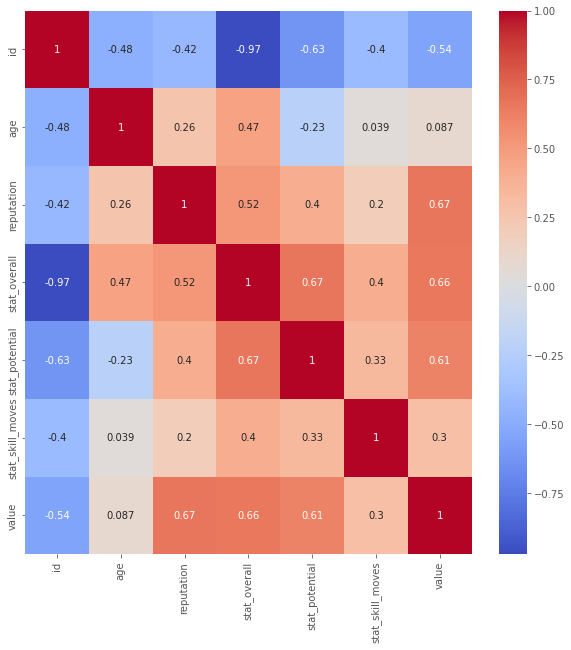

In [173]:
#데이터 전처리

tmp = train_df.corr()
plt.figure(figsize=(10,10))
plt.style.use('ggplot')
sns.heatmap(tmp, cmap='coolwarm', annot=True)

### value 에 영향을 미치는값의 분석


- reputation(0.67, 인기), stat_overall(0.66, 능력치), stat_potential(0.61, 성장가능성)

- value 값은 위 3개의 요소에 가장 많은 영향을 받는다.

- value(이적 시장 가격)와 관계가 높은 것은 'stat_overall', 'reputation', 'stat_potential'







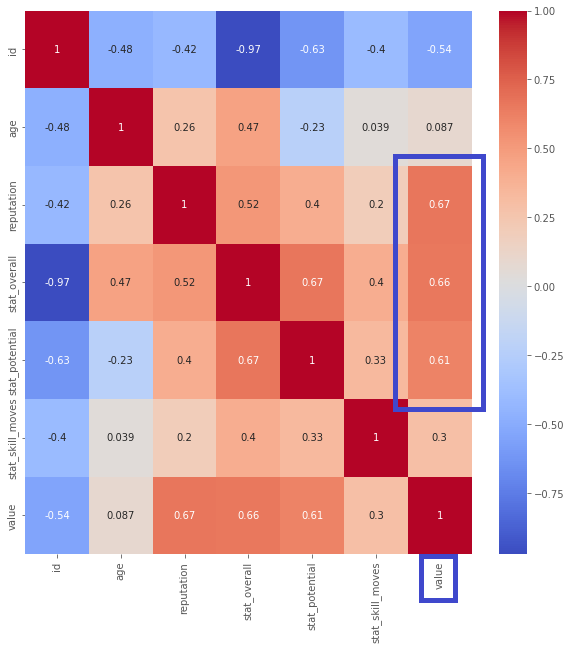



<AxesSubplot:xlabel='stat_overall', ylabel='value'>

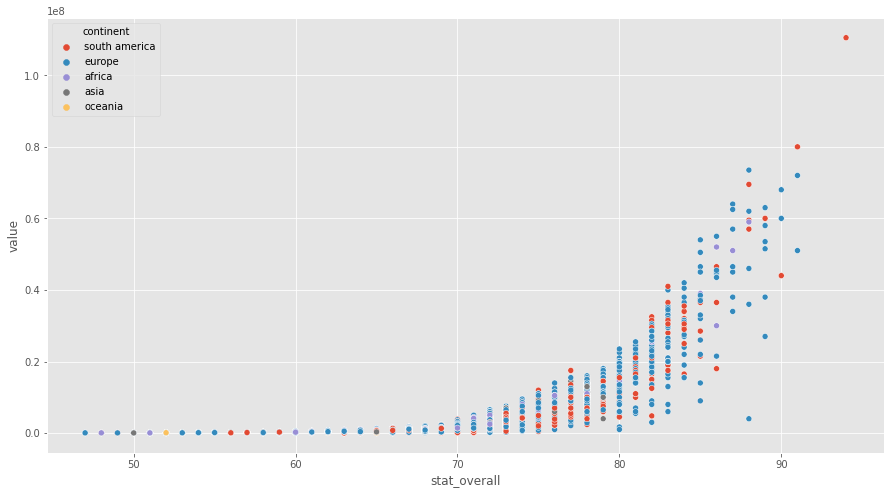

In [174]:
plt.figure(figsize=(15,8))
plt.style.use('ggplot')
sns.scatterplot(data=train_df, x='stat_overall', y ='value',hue='continent')

<Figure size 1080x576 with 0 Axes>

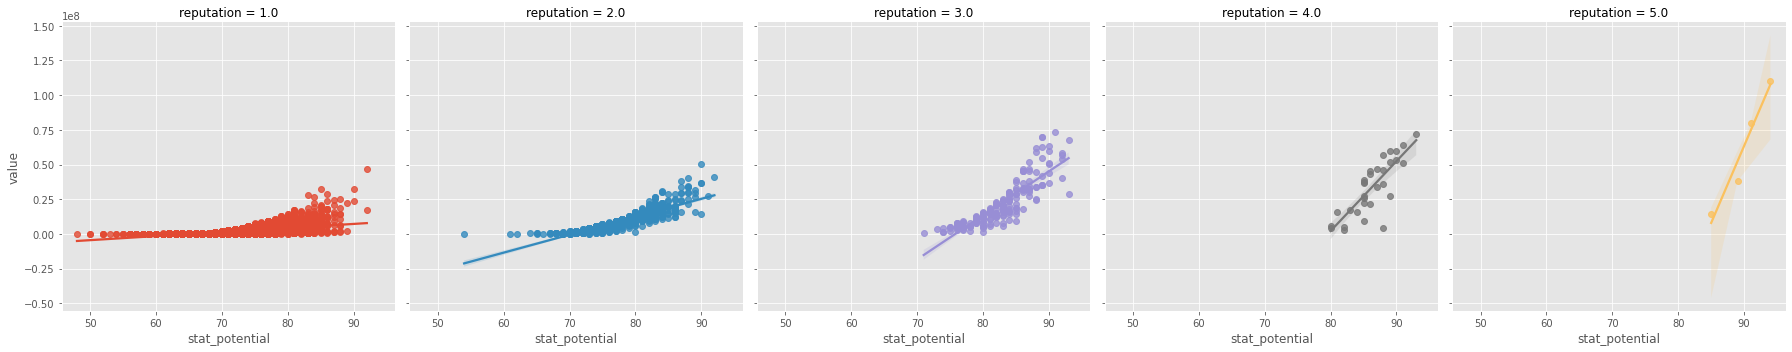

In [285]:
plt.figure(figsize=(15,8))
sns.lmplot(data=train_df, x='stat_potential', y ='value',col='reputation',hue='reputation')

# reputation이 높아질수록 value값이 가파르게 높아지고, stat_potential 또한 평균값이 높았다.

# 시각화

1. 축구선수에게 가장 중요한 value값을 기준으로 가장 관련있는 요소를 통해 시각화 진행
    - reputation(0.67, 인기), stat_overall(0.66, 능력치), stat_potential(0.61, 성장가능성)



2. value 값 외 대륙을 나타내는 continent(대륙)값 별로 value을 분류
    - continent(대륙)을 기준으로 선택한 이유 : 데이터 속성의 갯수가 분류 하기 적절함



3. 숫자형 자료와, 문자형 자료를 나눠서 진행
    - 숫자형 자료 \
    ['age', 'stat_overall', 'stat_potential']
    
    - 문자형 자료\
    ['continent', 'contract_until' ,'position', 'prefer_foot', 'reputation', 'stat_skill_moves'] 


In [537]:
tmp_df = train_df[['value','reputation','stat_potential','age']]
tmp_df = tmp_df[(tmp_df['value']>= 18000000) & (tmp_df['reputation']<5)]
tmp_df = tmp_df.sort_values(by = ['reputation','value'], ascending=True)
tmp_df['value'] = tmp_df['value']/1000000
tmp_df['reputation'] = tmp_df['reputation']*15
tmp_df['stat_potential'] = tmp_df['stat_potential']/5

tmp_df

value  reputation  stat_potential  age
333   18.0        15.0            17.2   20
336   18.0        15.0            17.2   21
337   18.0        15.0            17.2   20
345   18.0        15.0            17.2   20
253   18.5        15.0            17.6   22
..     ...         ...             ...  ...
22    57.0        60.0            17.6   30
6     60.0        60.0            18.0   32
11    60.0        60.0            17.8   31
26    64.0        60.0            18.2   25
1     72.0        60.0            18.6   27

[212 rows x 4 columns]

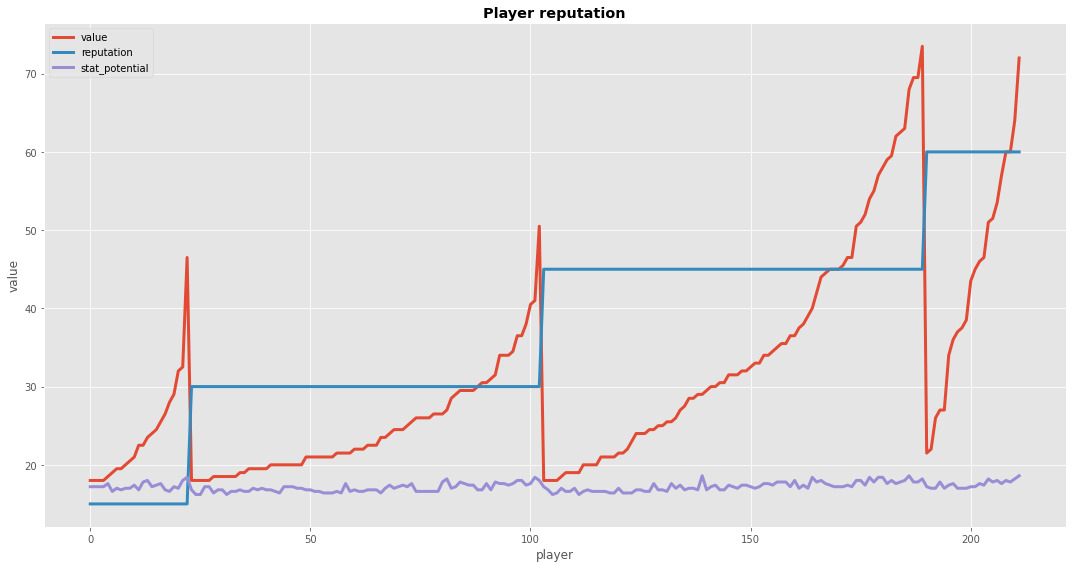

In [541]:
fig=plt.figure(figsize=(15,8))


import os
from PIL import Image
from IPython.display import Image as Img
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib as mpl
from matplotlib import font_manager, rc
import sys
import imageio
from PIL import Image
#imageio.plugins.ffmpeg.download()

data1 =  pd.to_numeric(tmp_df['value'], downcast='float')
data2 =  pd.to_numeric(tmp_df['reputation'], downcast='float')
data3 =  pd.to_numeric(tmp_df['stat_potential'], downcast='float')
#data4 =  pd.to_numeric(tmp['stat_overall'],  downcast='float')


def animate(i):
    x = np.linspace(0,i,i+1)
    y1 = data1[:i+1]
    y2 = data2[:i+1]
    y3 = data3[:i+1] 
    #y4 = data4[:i+1] 
    
    plt.cla()
    plt.plot(x, y1, label='value', lw=3)
    plt.plot(x, y2, label='reputation', lw=3)
    plt.plot(x, y3, label='stat_potential', lw=3)
    #plt.plot(x, y4, label='stat_overall', lw=3)
    
    plt.title('Player reputation', fontweight='bold')
    plt.ylabel('value')
    plt.xlabel('player')
    plt.legend(loc='upper left')
    plt.tight_layout()
    
ani = FuncAnimation(plt.gcf(), animate, frames=212, interval=1)
ani.save('./animation_single.gif', fps=30)

Img(url='animation_single.gif')
#print('GIF_make_finish')


## value, stat_potential의 관계

- 같은 reputation 등급에서 value 와 stat_potential의 관계를 시각화

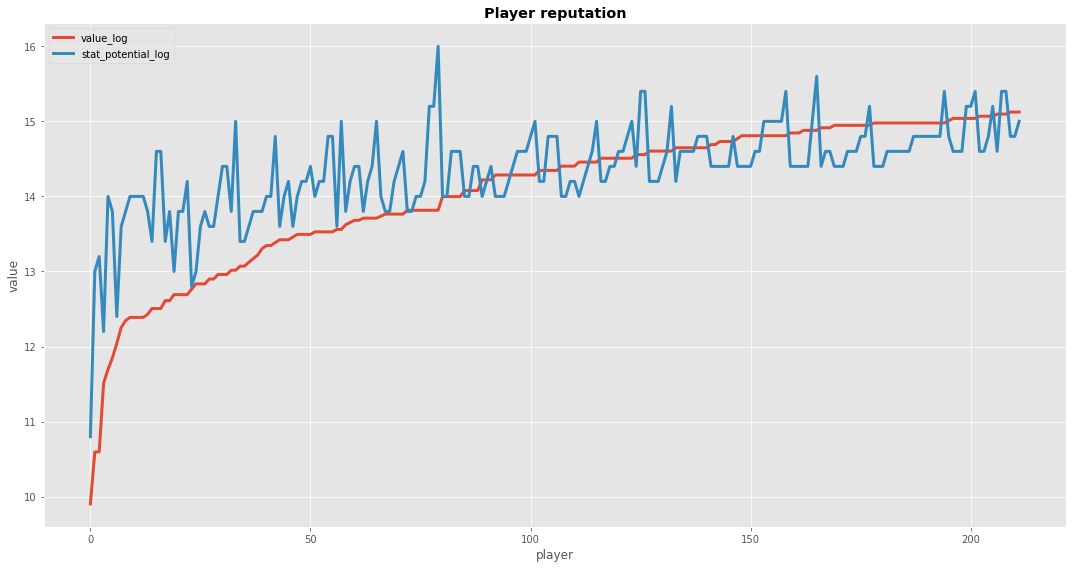

In [596]:
tmp_data_2 = train_df[['value','reputation','stat_potential']]
tmp_df = tmp_data_2.sort_values(by = ['value','reputation'], ascending=True)
tmp_df = tmp_df[(tmp_df['reputation']==2)]
tmp_df = tmp_df.sort_values(by = ['value','stat_potential'], ascending=True)
tmp_df['value_log'] = np.log(tmp_df['value'])
tmp_df['stat_potential_log'] = tmp_df['stat_potential']/5
tmp_df

fig=plt.figure(figsize=(15,8))


import os
from PIL import Image
from IPython.display import Image as Img
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib as mpl
from matplotlib import font_manager, rc
import sys
import imageio
from PIL import Image
#imageio.plugins.ffmpeg.download()

data1 =  pd.to_numeric(tmp_df['value_log'], downcast='float')
#data2 =  pd.to_numeric(tmp_df['reputation'], downcast='float')
data3 =  pd.to_numeric(tmp_df['stat_potential_log'], downcast='float')
#data4 =  pd.to_numeric(tmp['stat_overall'],  downcast='float')


def animate(i):
    x = np.linspace(0,i,i+1)
    y1 = data1[:i+1]
    #y2 = data2[:i+1] * 9000000
    y3 = data3[:i+1]
    #y4 = data4[:i+1] 
    
    plt.cla()
    plt.plot(x, y1, label='value_log', lw=3)
    #plt.plot(x, y2, label='reputation', lw=3)
    plt.plot(x, y3, label='stat_potential_log', lw=3)
    #plt.plot(x, y4, label='stat_overall', lw=3)
    
    plt.title('Player reputation', fontweight='bold')
    plt.ylabel('value')
    plt.xlabel('player')
    plt.legend(loc='upper left')
    plt.tight_layout()
    
ani = FuncAnimation(plt.gcf(), animate, frames=212, interval=1)
ani.save('./animation_single2.gif', fps=30)

Img(url='animation_single2.gif')
#print('GIF_make_finish')

##  시각화2

- 데이터를 나눠서 진행

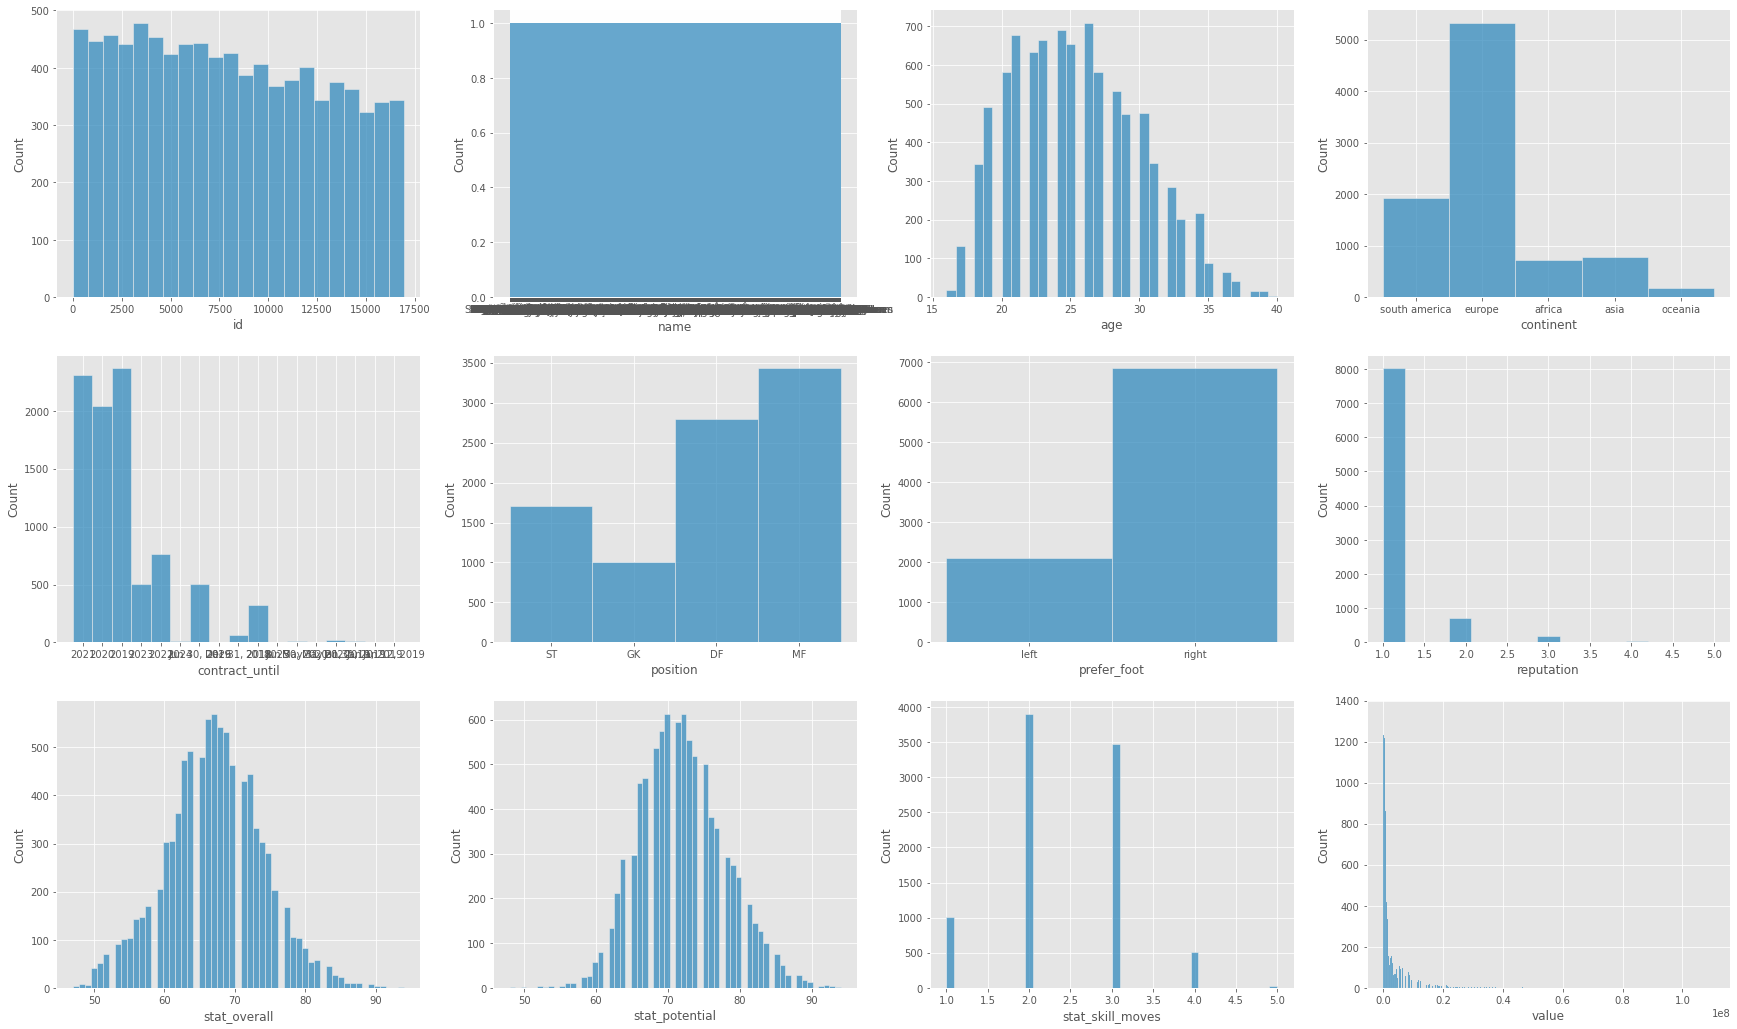

In [155]:
f, axes = plt.subplots(3,4, figsize=(30,18))
axes = axes.flatten()
for col, ax in zip(train_df.columns, axes):
  sns.histplot(data = train_df, x=col, ax=ax)
plt.show()

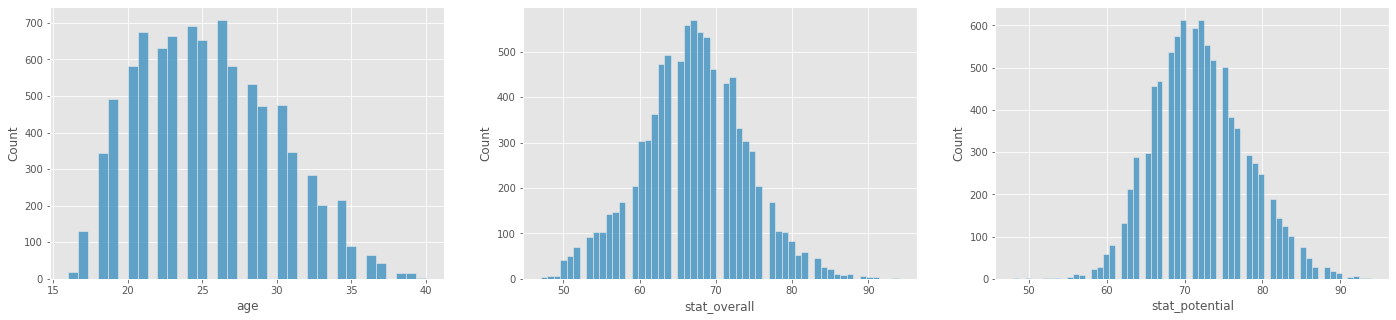

In [156]:
nums = ['age', 'stat_overall', 'stat_potential']

f, axes = plt.subplots(1,len(nums), figsize=(24,5))
axes = axes.flatten()                         
for col, ax in zip(nums, axes):
  sns.histplot(data = train_df, x=col, ax=ax)
plt.show()

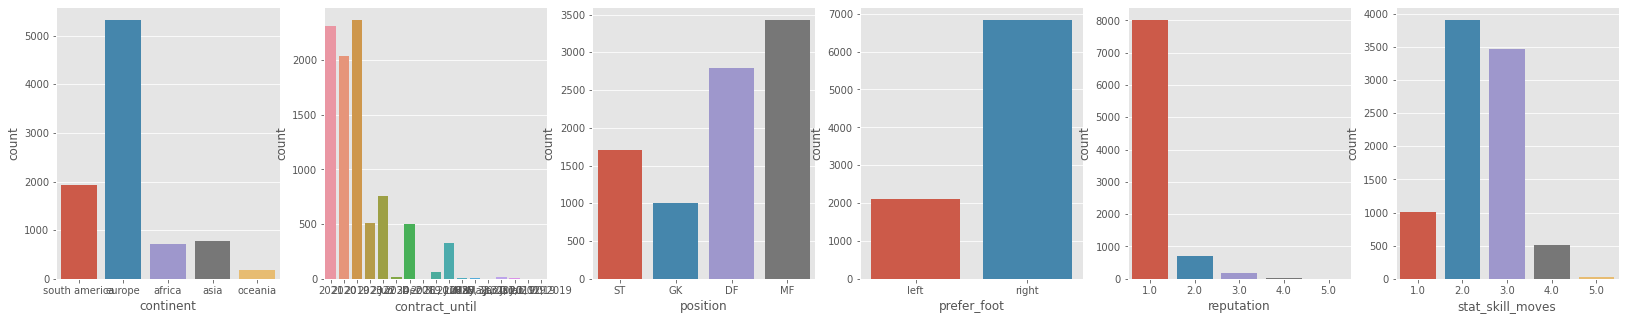

In [157]:
noms = ['continent', 'contract_until' ,'position', 'prefer_foot', 'reputation', 'stat_skill_moves'] # 이산형 (nominal)
f, axes = plt.subplots(1,len(noms), figsize=(28,5))
axes = axes.flatten()                         
for col, ax in zip(noms, axes):
  sns.countplot(data = train_df, x=col, ax=ax) 
plt.show()

###  포지션별 몸값
- 포지션 별로 value값을 봤을때, 차이가 유의미 하게 보인다.
  - ST, MF, DF, GK 순으로 높다.

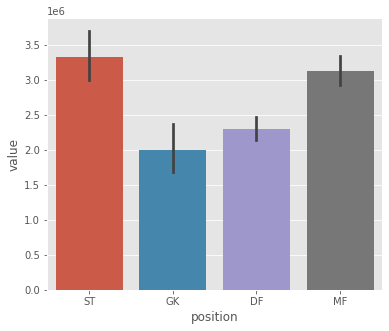

In [163]:
f, axes = plt.subplots(figsize=(6,5))
y = 'value'
sns.barplot(data = train_df, x='position', y=y) # 포지션과 몸값 사이의 관계
plt.show()

### 주로 사용하는 발에 따른 value

- 사용하는 발에 따라 value가 차이나는지 확인
  - prefer_foot에 따른 value는 크게 차이 나지 않는것을 확인

In [628]:
tmp = train_df['prefer_foot'].value_counts()
tmp

1    6837
0    2095
Name: prefer_foot, dtype: int64

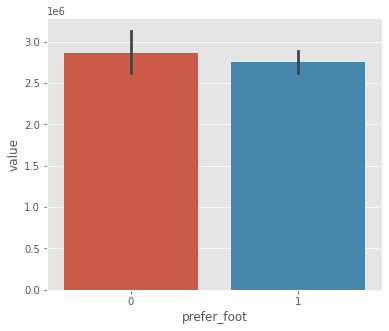

In [626]:
f, axes = plt.subplots(figsize=(6,5))       

sns.barplot(data = train_df, x='prefer_foot', y=y) # 주로쓰는 발과 몸값 사이의 관계

plt.show()



### 대륙별로 분류 후 시각화

- 대륙 별로 분류한 이유, 적당한  unique  값을 가지고 있기 때문에

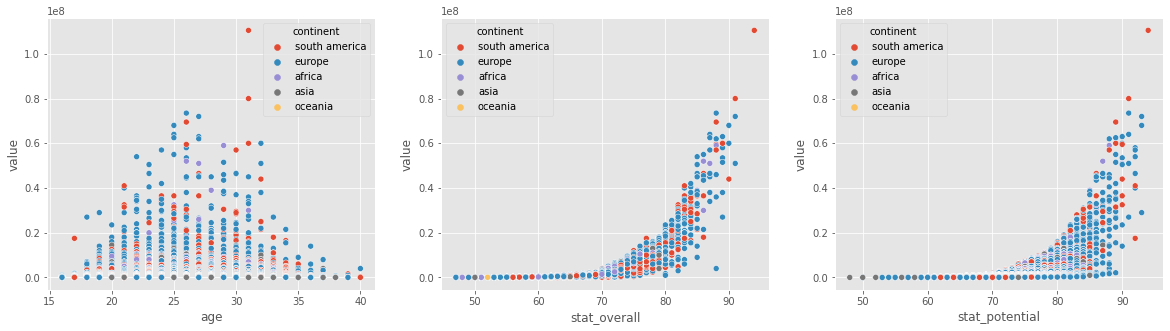

In [193]:
f, axes = plt.subplots(1,len(nums), figsize=(20,5))
axes = axes.flatten()                         
for col, ax in zip(nums, axes):
  sns.scatterplot(data = train_df, x=col, y=y, ax=ax, hue = 'continent') # 대륙별로 색을 지정
plt.show()

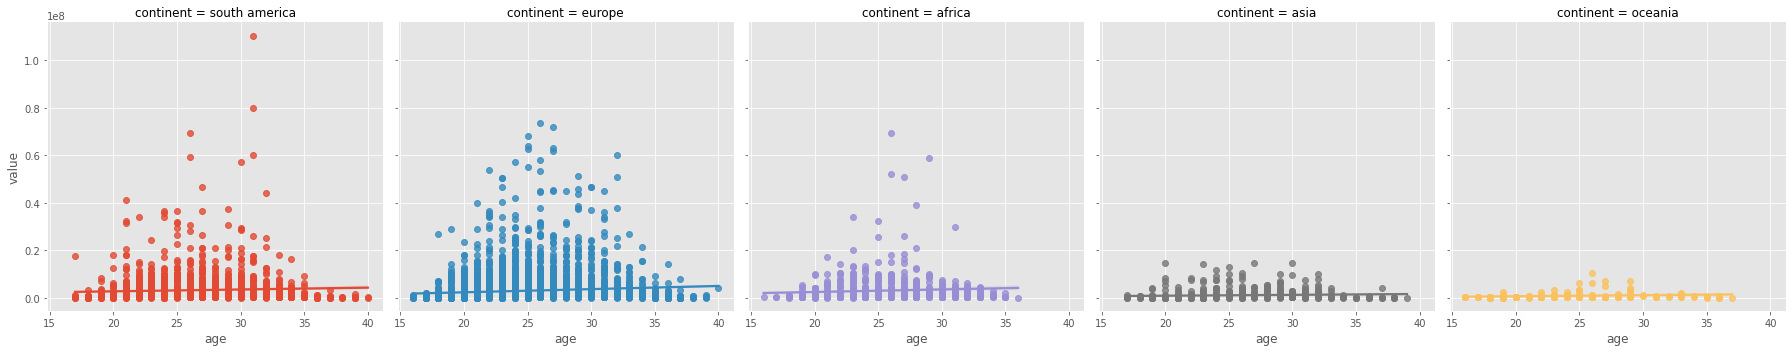

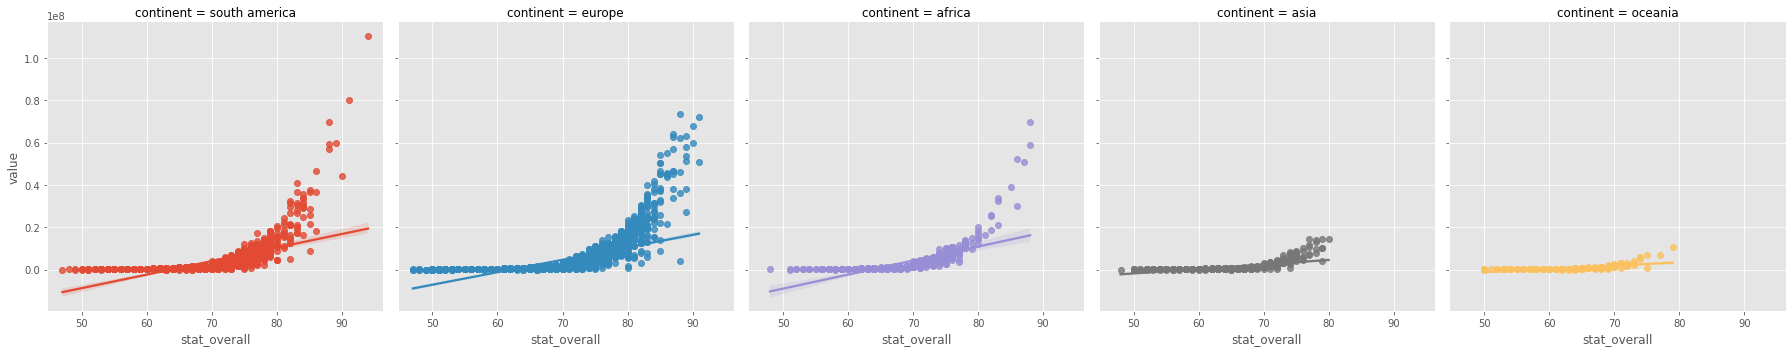

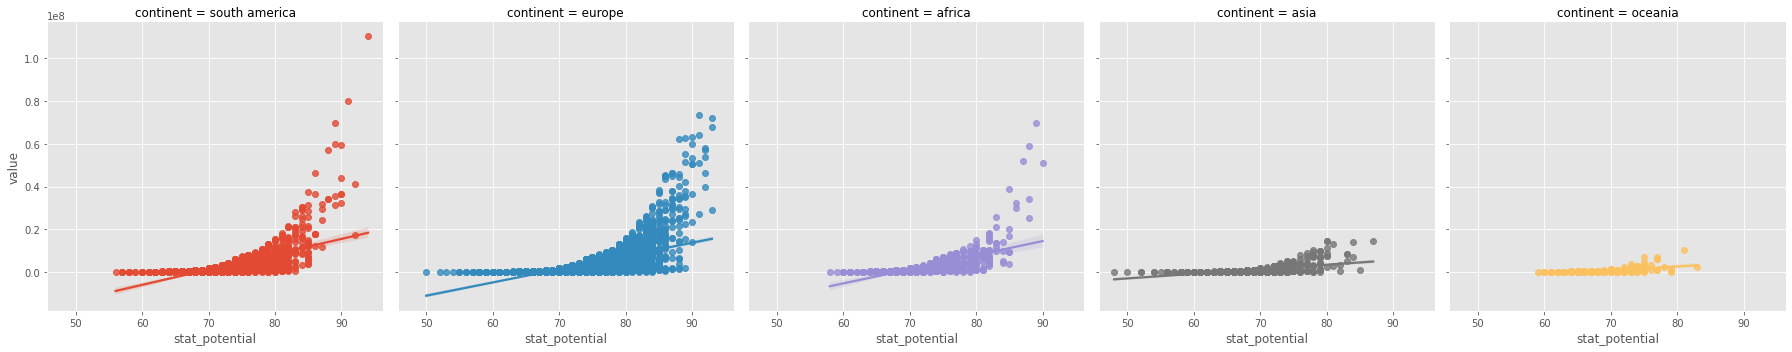

In [195]:
for col, ax in zip(nums, axes):
  sns.lmplot(data = train_df, x=col, y=y, hue='continent', col='continent') # 대륙별로 위 그래프를 분리
  plt.show()

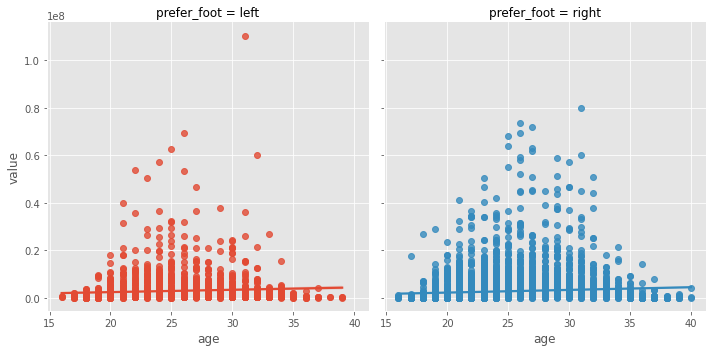

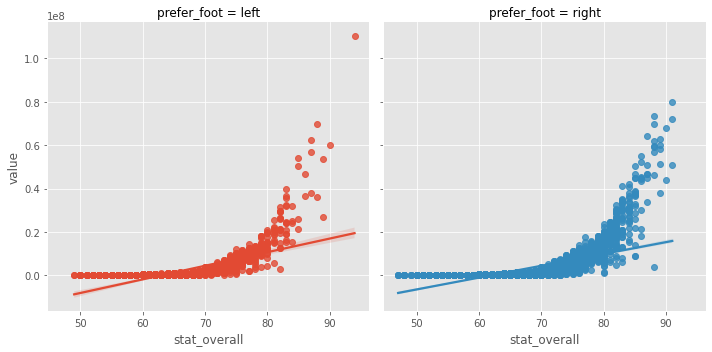

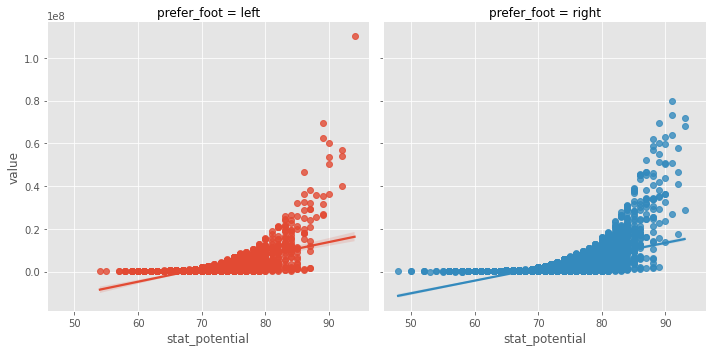

In [196]:
for col, ax in zip(nums, axes):
  sns.lmplot(data = train_df, x=col, y=y, hue='prefer_foot', col='prefer_foot') # 선호하는 발로 그래프를 분리
  plt.show()

In [618]:
tmp_data = train_df.copy()
tmp_data['age_group'] = [0]*len(tmp_data)
tmp_data.loc[(train_df['age']>=27)& (train_df['age']<=32), 'age_group'] = '27 ~ 32'
tmp_data.loc[train_df['age']< 27, 'age_group'] = '27down'
tmp_data.loc[train_df["age"] > 32, "age_group"] = "32up"

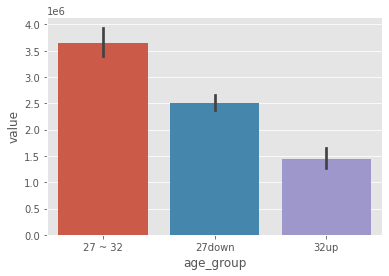

In [619]:
g = sns.barplot(x = "age_group", y = "value", data = tmp_data)
tmp_data["age_group"] = tmp_data["age_group"].astype("category")

## 데이터 학습

In [206]:
features = ['reputation', 'stat_overall','stat_potential']
X_train = train[features]
y_train = train['value']
X_test = test[features]


In [209]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(bootstrap=True, n_estimators=200, max_depth=5, random_state=0)
model.fit(X_train, y_train)
RandomForestRegressor(max_depth=5, n_estimators=200, random_state=0)


RandomForestRegressor(max_depth=5, n_estimators=200, random_state=0)

In [233]:
y_pred = model.predict(X_test)

submission_df['value'] = y_pred.astype('int')

submission_df.to_csv('model.csv', index=False)

In [588]:
sub_df = pd.read_csv('model.csv')
sub_df

id     value
0         1  94127748
1         2  71501479
2         4  61274391
3         5  61506981
4         6  61506981
...     ...       ...
3823  16924    169331
3824  16929    169331
3825  16932    169331
3826  16937    169331
3827  16943    169331

[3828 rows x 2 columns]

In [591]:
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import time

In [592]:
# aseline code

# 불필요한 컬럼 제거
train_df.drop(['id', 'name'], axis = 1, inplace = True)
test_df.drop(['id', 'name'], axis = 1, inplace = True)

#contract_until 변수 int 형으로 변환
# 계약 연도만 추출
def func(string:object) -> int:
    """계약 연도만 추출하여 int로 반환"""
    string = string[-4:]
    return int(string)

train_df['contract_until'] = train_df['contract_until'].apply(func)
test_df['contract_until'] = test_df['contract_until'].apply(func)

# 문자형 변수 label 인코딩 진행
train_df['continent'] = train_df['continent'].astype('category').cat.codes
test_df['continent'] = test_df['continent'].astype('category').cat.codes

train_df['position'] = train_df['position'].astype('category').cat.codes
test_df['position'] = test_df['position'].astype('category').cat.codes

train_df['prefer_foot'] = train_df['prefer_foot'].astype('category').cat.codes
test_df['prefer_foot'] = test_df['prefer_foot'].astype('category').cat.codes

# string형 변수 변환 완료
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               8932 non-null   int64  
 1   continent         8932 non-null   int8   
 2   contract_until    8932 non-null   int64  
 3   position          8932 non-null   int8   
 4   prefer_foot       8932 non-null   int8   
 5   reputation        8932 non-null   float64
 6   stat_overall      8932 non-null   int64  
 7   stat_potential    8932 non-null   int64  
 8   stat_skill_moves  8932 non-null   float64
 9   value             8932 non-null   float64
dtypes: float64(3), int64(4), int8(3)
memory usage: 514.8 KB


In [597]:
y_target = train_df['value']
X_data  = train_df.drop(['value'], axis = 1, inplace = False)

start_time = time.time()
rf = RandomForestRegressor(random_state=0, n_estimators=1000)
neg_mse_scores = cross_val_score(rf, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
rmse_scores  = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print(' 실행시간 {0:.0f}초'.format(time.time() - start_time))

print(' 5 교차 검증의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 2))
print(' 5 교차 검증의 개별 RMSE scores : ', np.round(rmse_scores, 2))
print(' 5 교차 검증의 평균 RMSE : {0:.3f} '.format(avg_rmse))

 실행시간 37초
 5 교차 검증의 개별 Negative MSE scores:  [-1.23080444e+14 -7.07191018e+11 -2.13689716e+10 -1.36563461e+10
 -3.88981781e+10]
 5 교차 검증의 개별 RMSE scores :  [11094162.6    840946.5    146181.3    116860.37   197226.21]
 5 교차 검증의 평균 RMSE : 2479075.397 


In [599]:
def get_model_cv_prediction(model, X_data, y_target):
    start_time = time.time()
    neg_mse_scores = cross_val_score(model, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
    rmse_scores  = np.sqrt(-1 * neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)
    print('##### ',model.__class__.__name__ , ' #####')
    print(' 실행시간 {0:.0f}초'.format(time.time() - start_time))
    print(' 5 교차 검증의 평균 RMSE : {0:.3f} \n'.format(avg_rmse))

In [600]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings(action='ignore')

dt_reg = DecisionTreeRegressor(random_state=0, max_depth=4)
rf_reg = RandomForestRegressor(random_state=0, n_estimators=1000)
gb_reg = GradientBoostingRegressor(random_state=0, n_estimators=1000)
xgb_reg = XGBRegressor(n_estimators=1000)
lgb_reg = LGBMRegressor(n_estimators=1000)

# 트리 기반의 회귀 모델을 반복하면서 평가 수행 
models = [dt_reg, rf_reg, gb_reg, xgb_reg, lgb_reg]
for model in models:  
    get_model_cv_prediction(model, X_data, y_target)

#####  DecisionTreeRegressor  #####
 실행시간 0초
 5 교차 검증의 평균 RMSE : 2791965.170 

#####  RandomForestRegressor  #####
 실행시간 36초
 5 교차 검증의 평균 RMSE : 2479075.397 

#####  GradientBoostingRegressor  #####
 실행시간 12초
 5 교차 검증의 평균 RMSE : 2425193.339 

#####  XGBRegressor  #####
 실행시간 4초
 5 교차 검증의 평균 RMSE : 2506302.748 

#####  LGBMRegressor  #####
 실행시간 2초
 5 교차 검증의 평균 RMSE : 2453434.732 



<AxesSubplot:>

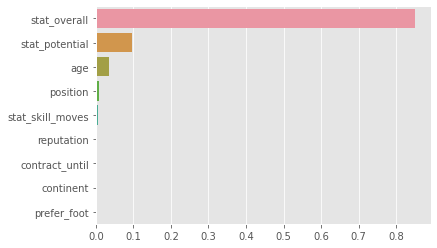

In [601]:
import seaborn as sns

rf_reg = RandomForestRegressor(n_estimators=1000)

# 앞 예제에서 만들어진 X_data, y_target 데이터 셋을 적용하여 학습합니다.   
rf_reg.fit(X_data, y_target)

feature_series = pd.Series(data=rf_reg.feature_importances_, index=X_data.columns )
feature_series = feature_series.sort_values(ascending=False)
sns.barplot(x= feature_series, y=feature_series.index)

(200, 2)


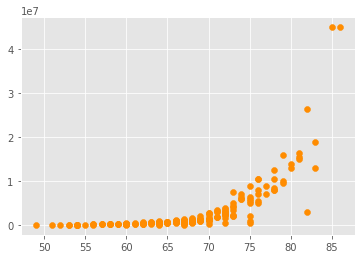

In [604]:
import matplotlib.pyplot as plt

train_df_sample = train_df[['stat_overall','value']]
train_df_sample = train_df_sample.sample(n=200,random_state=0)
print(train_df_sample.shape)
plt.figure()
plt.scatter(train_df_sample['stat_overall'] , train_df_sample['value'],c="darkorange")

plt.show()

In [605]:
import numpy as np
from sklearn.linear_model import LinearRegression

# 선형 회귀와 결정 트리 기반의 Regressor 생성. DecisionTreeRegressor의 max_depth는 각각 2, 7
lr_reg = LinearRegression()
rf_reg2 = DecisionTreeRegressor(max_depth=2)
rf_reg7 = DecisionTreeRegressor(max_depth=7)

# 실제 예측을 적용할 테스트용 데이터 셋을 4.5 ~ 8.5 까지 100개 데이터 셋 생성. 
X_test = np.arange(4.5, 8.5, 0.04).reshape(-1, 1)

# 보스턴 주택가격 데이터에서 시각화를 위해 피처는 RM만, 그리고 결정 데이터인 PRICE 추출
X_feature = train_df_sample['stat_overall'].values.reshape(-1,1)
y_target = train_df_sample['value'].values.reshape(-1,1)

# 학습과 예측 수행. 
lr_reg.fit(X_feature, y_target)
rf_reg2.fit(X_feature, y_target)
rf_reg7.fit(X_feature, y_target)

pred_lr = lr_reg.predict(X_test)
pred_rf2 = rf_reg2.predict(X_test)
pred_rf7 = rf_reg7.predict(X_test)

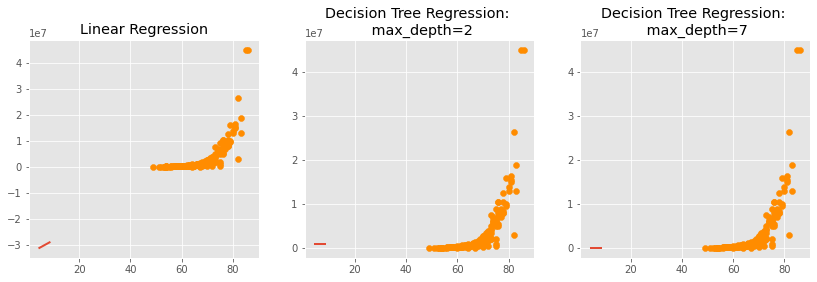

In [606]:
fig , (ax1, ax2, ax3) = plt.subplots(figsize=(14,4), ncols=3)

# X축값을 4.5 ~ 8.5로 변환하며 입력했을 때, 선형 회귀와 결정 트리 회귀 예측 선 시각화
# 선형 회귀로 학습된 모델 회귀 예측선 
ax1.set_title('Linear Regression')
ax1.scatter(train_df_sample.stat_overall, train_df_sample.value, c="darkorange")
ax1.plot(X_test, pred_lr,label="linear", linewidth=2 )

# DecisionTreeRegressor의 max_depth를 2로 했을 때 회귀 예측선 
ax2.set_title('Decision Tree Regression: \n max_depth=2')
ax2.scatter(train_df_sample.stat_overall, train_df_sample.value, c="darkorange")
ax2.plot(X_test, pred_rf2, label="max_depth:3", linewidth=2 )

# DecisionTreeRegressor의 max_depth를 7로 했을 때 회귀 예측선 
ax3.set_title('Decision Tree Regression: \n max_depth=7')
ax3.scatter(train_df_sample.stat_overall, train_df_sample.value, c="darkorange")
ax3.plot(X_test, pred_rf7, label="max_depth:7", linewidth=2)

plt.show()

In [607]:
import xgboost as xgb
print(xgb.__version__)

1.6.1


In [608]:
from xgboost import plot_importance
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

train_df

age  continent  contract_until  position  prefer_foot  reputation  \
0      31          4            2021         3            0         5.0   
1      27          2            2020         1            1         4.0   
2      31          4            2021         3            1         5.0   
3      32          2            2020         0            1         4.0   
4      25          2            2021         1            1         3.0   
...   ...        ...             ...       ...          ...         ...   
8927   18          0            2019         2            1         1.0   
8928   19          2            2020         0            1         1.0   
8929   18          4            2021         0            1         1.0   
8930   18          2            2021         1            1         1.0   
8931   19          2            2020         3            1         1.0   

      stat_overall  stat_potential  stat_skill_moves        value  
0               94              94               4.0  110500000.0  
1               91              93               1.0   72000000.0  
2               91              91               3.0   80000000.0  
3               91              91               3.0   51000000.0  
4               90              93               1.0   68000000.0  
...            ...             ...               ...          ...  
8927            48              63               3.0      60000.0  
8928            47              59               2.0      40000.0  
8929            47              64               2.0      50000.0  
8930            47              65               1.0      50000.0  
8931            47              63               2.0      60000.0  

[8932 rows x 10 columns]

In [610]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train ,y_train)
w_pred = xgb_wrapper.predict(X_test)

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197], got [1.000e+04 2.000e+04 3.000e+04 4.000e+04 5.000e+04 6.000e+04 7.000e+04
 8.000e+04 9.000e+04 1.000e+05 1.100e+05 1.200e+05 1.300e+05 1.400e+05
 1.500e+05 1.600e+05 1.700e+05 1.800e+05 1.900e+05 2.000e+05 2.100e+05
 2.200e+05 2.300e+05 2.400e+05 2.500e+05 2.600e+05 2.700e+05 2.800e+05
 2.900e+05 3.000e+05 3.250e+05 3.500e+05 3.750e+05 4.000e+05 4.250e+05
 4.500e+05 4.750e+05 5.000e+05 5.250e+05 5.500e+05 5.750e+05 6.000e+05
 6.250e+05 6.500e+05 6.750e+05 7.000e+05 7.250e+05 7.500e+05 7.750e+05
 8.000e+05 8.250e+05 8.500e+05 8.750e+05 9.000e+05 9.250e+05 9.500e+05
 9.750e+05 1.000e+06 1.100e+06 1.200e+06 1.300e+06 1.400e+06 1.500e+06
 1.600e+06 1.700e+06 1.800e+06 1.900e+06 2.000e+06 2.100e+06 2.200e+06
 2.300e+06 2.400e+06 2.500e+06 2.600e+06 2.700e+06 2.800e+06 2.900e+06
 3.000e+06 3.100e+06 3.200e+06 3.300e+06 3.400e+06 3.500e+06 3.600e+06
 3.700e+06 3.800e+06 3.900e+06 4.000e+06 4.100e+06 4.200e+06 4.300e+06
 4.400e+06 4.500e+06 4.600e+06 4.700e+06 4.800e+06 4.900e+06 5.000e+06
 5.500e+06 6.000e+06 6.500e+06 7.000e+06 7.500e+06 8.000e+06 8.500e+06
 9.000e+06 9.500e+06 1.000e+07 1.050e+07 1.100e+07 1.150e+07 1.200e+07
 1.250e+07 1.300e+07 1.350e+07 1.400e+07 1.450e+07 1.500e+07 1.550e+07
 1.600e+07 1.650e+07 1.700e+07 1.750e+07 1.800e+07 1.850e+07 1.900e+07
 1.950e+07 2.000e+07 2.050e+07 2.100e+07 2.150e+07 2.200e+07 2.250e+07
 2.300e+07 2.350e+07 2.400e+07 2.450e+07 2.500e+07 2.550e+07 2.600e+07
 2.650e+07 2.700e+07 2.750e+07 2.800e+07 2.850e+07 2.900e+07 2.950e+07
 3.000e+07 3.050e+07 3.100e+07 3.150e+07 3.200e+07 3.250e+07 3.300e+07
 3.400e+07 3.450e+07 3.500e+07 3.550e+07 3.600e+07 3.650e+07 3.700e+07
 3.750e+07 3.800e+07 3.850e+07 3.900e+07 4.000e+07 4.050e+07 4.100e+07
 4.200e+07 4.350e+07 4.400e+07 4.450e+07 4.500e+07 4.550e+07 4.600e+07
 4.650e+07 5.050e+07 5.100e+07 5.150e+07 5.200e+07 5.350e+07 5.400e+07
 5.500e+07 5.700e+07 5.800e+07 5.900e+07 5.950e+07 6.000e+07 6.200e+07
 6.250e+07 6.300e+07 6.400e+07 6.800e+07 6.950e+07 7.200e+07 7.350e+07
 8.000e+07 1.105e+08]

## 모델링

- 랜덤 포레스트, xgboost 사용예정,
    - train_df = train 데이터
    - test_df = test 데이터
 

In [123]:
from sklearn.ensemble import RandomForestRegressor

train_x = train_df.drop('value',axis = 1)
train_y = train_df['value']


model = RandomForestRegressor()
model.fit(train_x,train_y)

RandomForestRegressor()